## Add test-train split for the linear regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Airbnb\listings_cleaned.csv')
df.head()

,id,name,price,room_type,number_of_reviews,stars,bed,bedroom,bath,neighbourhood,latitude,longitude,minimum_nights,last_review,reviews_per_month,number_of_reviews_ltm,calculated_host_listings_count,host_id
0,23986,Rental unit in Milan · ★4.64 · 1 bedroom · 1 b...,150.0,Entire home/apt,26.0,4.64,1.0,1.0,1.0,NAVIGLI,45.44806,9.17373,1.0,2023-07-29,0.18,4.0,1.0,95941
1,40470,Rental unit in Milan · ★4.67 · 2 bedrooms · 4 ...,80.0,Entire home/apt,41.0,4.67,4.0,2.0,1.0,VIALE MONZA,45.52023,9.22747,3.0,2023-09-09,0.26,3.0,2.0,174203
2,304050,Rental unit in Milan · ★4.91 · 1 bedroom · 1 b...,49.0,Private room,264.0,4.91,1.0,1.0,1.0,XXII MARZO,45.45709,9.21531,2.0,2023-11-21,1.92,33.0,2.0,1566887
3,46536,Rental unit in Milan · ★4.53 · 2 bedrooms · 3 ...,110.0,Entire home/apt,35.0,4.53,3.0,2.0,1.0,VIALE MONZA,45.52276,9.22478,3.0,2023-10-30,0.24,5.0,1.0,138683
4,333223,Rental unit in Milano · ★5.0 · 1 bedroom · 2 b...,150.0,Private room,3.0,5.00,2.0,1.0,1.0,MAGENTA - S. VITTORE,45.46097,9.16431,1.0,2023-04-19,0.02,1.0,5.0,1697947


### Handling outliers

#### Reviews Number

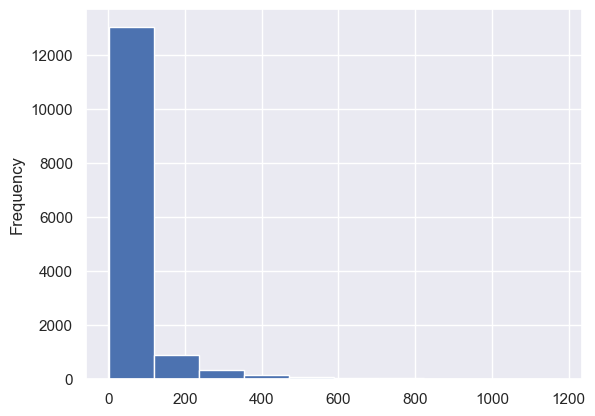

In [3]:
df['number_of_reviews'].plot.hist();

In [4]:
df.loc[df['number_of_reviews_ltm']>4, 'id'].count()

9332

In [5]:
# I keep just the listings with at least 5 reviews
# in the past 12 months

df = df[df['number_of_reviews_ltm']>4]

#### Price

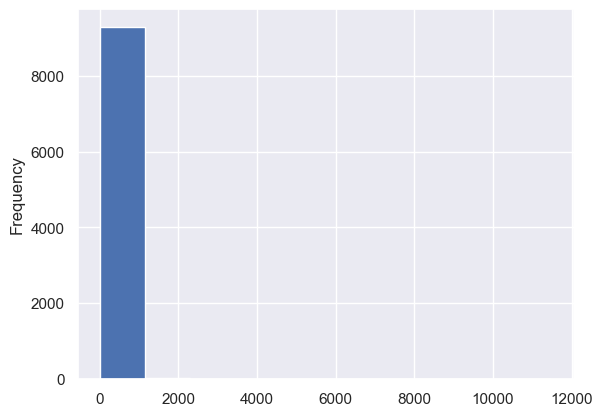

In [6]:
df['price'].plot.hist();

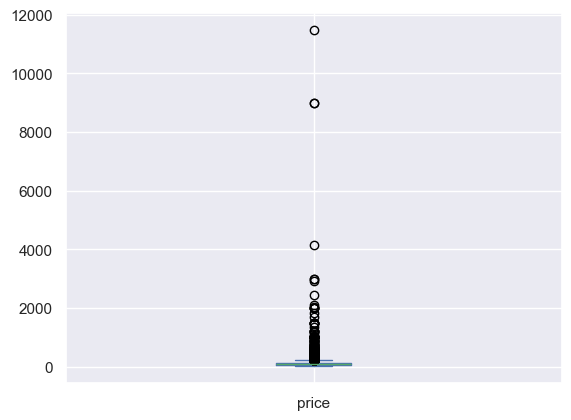

In [7]:
df['price'].plot.box();

In [8]:
def outliers(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    print(f'Low-Band Outlier: {q1-1.5*iqr}')
    print(f'High-Band Outlier: {q3+1.5*iqr}')
    print('------')
    print(f'Low-Band Extreme Outlier: {q1-3*iqr}')
    print(f'High-Band Extreme Outlier: {q3+3*iqr}')

outliers(df['price'])

Low-Band Outlier: -17.5
High-Band Outlier: 218.5
------
Low-Band Extreme Outlier: -106.0
High-Band Extreme Outlier: 307.0


In [9]:
# There are no listings that cost too little

df[df['price']<10]['id'].count()

0

In [10]:
# Since homes can vary a lot, I eclude just the extreme outliers

df[df['price']>316]['id'].count()

314

In [11]:
df = df[df['price'] < 317]

In [12]:
# No null col, nice!

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9018 entries, 2 to 14490
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              9018 non-null   int64  
 1   name                            9018 non-null   object 
 2   price                           9018 non-null   float64
 3   room_type                       9018 non-null   object 
 4   number_of_reviews               9018 non-null   float64
 5   stars                           9018 non-null   float64
 6   bed                             9018 non-null   float64
 7   bedroom                         9018 non-null   float64
 8   bath                            9018 non-null   float64
 9   neighbourhood                   9018 non-null   object 
 10  latitude                        9018 non-null   float64
 11  longitude                       9018 non-null   float64
 12  minimum_nights                  9018 n

### Data exploration

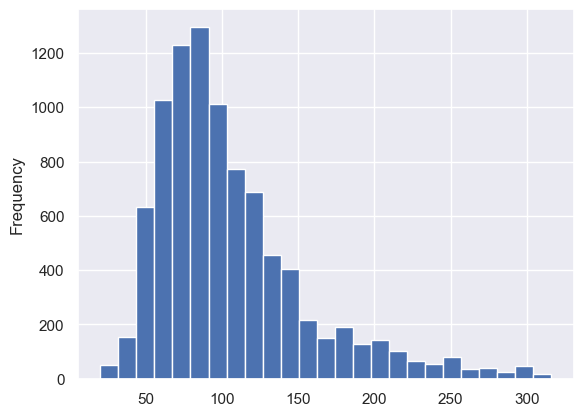

In [13]:
df['price'].plot.hist(bins=25);

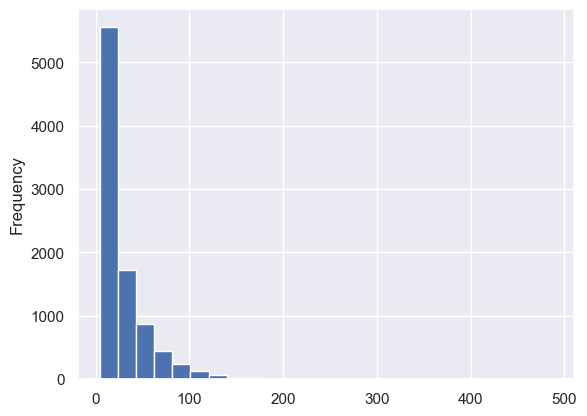

In [14]:
df['number_of_reviews_ltm'].plot.hist(bins=25);

In [15]:
df['minimum_nights'].value_counts()

minimum_nights
1.0      4044
2.0      3570
3.0       862
4.0       243
5.0       123
7.0        42
6.0        39
30.0       23
15.0       13
10.0       12
28.0       10
14.0        9
20.0        5
29.0        5
12.0        4
21.0        3
8.0         3
365.0       1
9.0         1
78.0        1
45.0        1
44.0        1
25.0        1
35.0        1
120.0       1
Name: count, dtype: int64

In [16]:
df = df[df['minimum_nights']<8]

## Revenue in the last 12 Months

There's no enough data to get the true revenue of the last 12 months. But we can get a proxy with this formula:

*Minimun number of nights * reviews in the last 12 months * price*

The result will be much less than the reality. But this is the best we can do with the available data.

The average number of nights per Airbnb booking in "Europe, Middle East, and Africa" in 2022 is 4.2.

[Source](https://www.statista.com/statistics/1193597/airbnb-average-nights-per-booking-by-region-worldwide/)

So it's likely that the listings with only 1,2,3,4 minimun nights will be much more biased with the formula above.

We adjust the formula to take everything closer to the mean:

- 1 minimun night --> multiply by 2
- 2 minimun nights --> multiply by 1.4
- 3 minimun nights --> multiply by 1.2
- 4 minimun nights --> multiply by 1.05

In [17]:
df['multiply'] = df['minimum_nights']
df.loc[df['minimum_nights']==1, 'multiply'] = 2
df.loc[df['minimum_nights']==2, 'multiply'] = 2*1.4
df.loc[df['minimum_nights']==3, 'multiply'] = 3*1.2
df.loc[df['minimum_nights']==4, 'multiply'] = 4*1.05

In [18]:
df['revenue_ltm'] = df['multiply'] * df['number_of_reviews_ltm'] * df['price']
df.head()

,id,name,price,room_type,number_of_reviews,stars,bed,bedroom,bath,neighbourhood,latitude,longitude,minimum_nights,last_review,reviews_per_month,number_of_reviews_ltm,calculated_host_listings_count,host_id,multiply,revenue_ltm
2,304050,Rental unit in Milan · ★4.91 · 1 bedroom · 1 b...,49.0,Private room,264.0,4.91,1.0,1.0,1.0,XXII MARZO,45.457090,9.215310,2.0,2023-11-21,1.92,33.0,2.0,1566887,2.8,4527.6
3,46536,Rental unit in Milan · ★4.53 · 2 bedrooms · 3 ...,110.0,Entire home/apt,35.0,4.53,3.0,2.0,1.0,VIALE MONZA,45.522760,9.224780,3.0,2023-10-30,0.24,5.0,1.0,138683,3.6,1980.0
9,84741,Loft in Milan · ★4.63 · 1 bedroom · 1 bed · 1 ...,39.0,Private room,569.0,4.63,1.0,1.0,1.0,PARCO FORLANINI - ORTICA,45.469994,9.244106,1.0,2023-12-18,3.71,52.0,2.0,443989,2.0,4056.0
11,348448,Rental unit in Milan · ★4.54 · Studio · 1 bed ...,99.0,Entire home/apt,137.0,4.54,1.0,0.0,1.0,BRERA,45.476170,9.188730,1.0,2023-11-26,1.00,38.0,1.0,326090,2.0,7524.0
12,90830,Loft in Milan · ★4.67 · 2 bedrooms · 3 beds · ...,91.0,Entire home/apt,186.0,4.67,3.0,2.0,1.0,NAVIGLI,45.446780,9.163470,1.0,2023-11-27,1.20,67.0,22.0,181255620,2.0,12194.0


### One-Hot Encoding

In [19]:
df['room_type'].value_counts()

room_type
Entire home/apt    7896
Private room        971
Shared room          55
Hotel room            1
Name: count, dtype: int64

In [20]:
# Drop the occurrences of Hotel room and Shared room

df = df[(df['room_type'] != 'Hotel room')&(df['room_type'] != 'Shared room')]

In [21]:
# Entire home/apt = 1
# Private room = 0

df['room'] = 1
df.loc[df['room_type']=='Private room','room'] = 0

In [22]:
neigh_count = df['neighbourhood'].value_counts()
neigh_count[5:10]

neighbourhood
LORETO        393
BRERA         380
TICINESE      364
ISOLA         320
XXII MARZO    244
Name: count, dtype: int64

In [23]:
print(neigh_count[neigh_count<50].count())
print(neigh_count[neigh_count>50].count())

37
43


In [24]:
neigh_count = neigh_count[neigh_count>30]
df = df[df['neighbourhood'].isin(neigh_count.index.to_list())]

In [25]:
# One hot encoding ['neighbourhood'

df = pd.concat([df,
           pd.get_dummies(df['neighbourhood'], dtype='float32', drop_first=True)],
           axis='columns')

### Linear Regression

In [26]:
col_to_keep = ['price','stars','bed','bedroom','bath','room'] + neigh_count.index.to_list()
col_to_keep.remove('AFFORI') # Because we dropped the 1st in get_dummies

X = df[col_to_keep]
y = df['revenue_ltm']

In [27]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

lm = LinearRegression()
lm.fit(X,y)

yhat = lm.predict(X)
print('R2: ', metrics.r2_score(y, yhat))
print('MSE: ', metrics.mean_squared_error(y, yhat))

R2:  0.2032891451797636
MSE:  40083729.08064365


In [38]:
# Standardizing the features doesn't change anything
# so I comment out this cell

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Fit the linear regression model on the standardized data
# model = LinearRegression()
# model.fit(X_scaled, y)

# yhat = model.predict(X_scaled)
# print('R2: ', metrics.r2_score(y, yhat))
# print('MSE: ', metrics.mean_squared_error(y, yhat))

R2:  0.20328914517976382
MSE:  40083729.08064364


c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

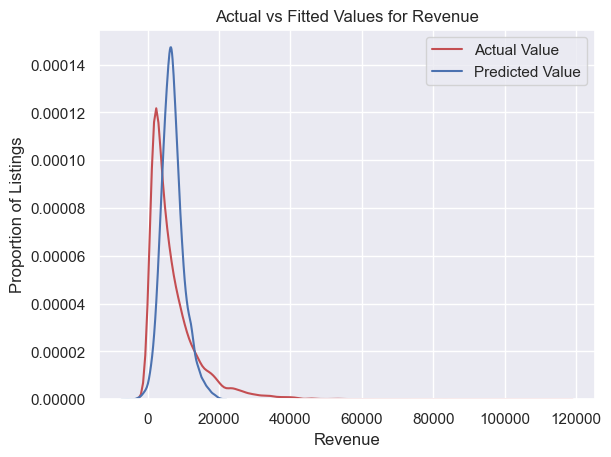

In [28]:
# ax1 = sns.displot(y, hist=False, color="r", label="Actual Value")
# sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)

ax1 = sns.kdeplot(y, color="r", label="Actual Value")
sns.kdeplot(yhat, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Revenue')
plt.xlabel('Revenue')
plt.ylabel('Proportion of Listings')
plt.legend(['Actual Value', 'Predicted Value'])
plt.show()


In [42]:
coefficients = lm.coef_

coefficients_dict = dict(zip(col_to_keep, coefficients))

df_coeff = pd.DataFrame(coefficients_dict, index=['coefficients']).T

In [46]:
df_coeff.sort_values(ascending=False, by='coefficients')

,coefficients
DUOMO,5312.045904
stars,4946.993292
CENTRALE,3539.109772
BRERA,3404.228359
MAGENTA - S. VITTORE,2764.844408
TICINESE,2599.471461
PAGANO,1941.029105
MACIACHINI - MAGGIOLINA,1829.479779
BUENOS AIRES - VENEZIA,1797.666087
NAVIGLI,1693.747836


### Polynomial Regression

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Rsqu_test = []

order = [1, 2]
for n in order:
    lr = LinearRegression()
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train)
    
    x_test_pr = pr.fit_transform(x_test)    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))
    print(f'Done: {n}')

Done: 1
Done: 2


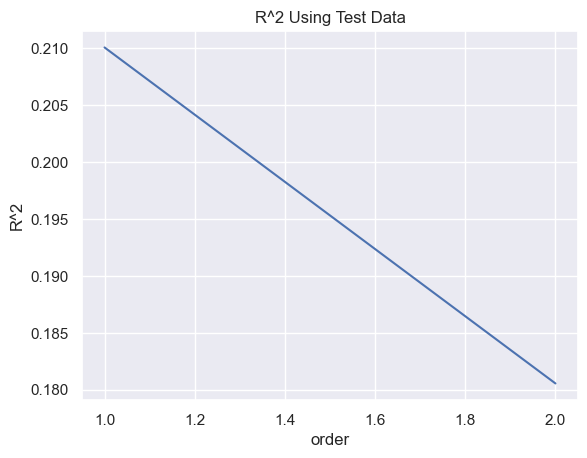

In [34]:
plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data');